In [1]:
import streamlit as st
# To make things easier later, we're also importing numpy and pandas for
# working with sample data.
import numpy as np
import pandas as pd

import librosa.display
import librosa
import pydub
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
from pydub import AudioSegment

In [2]:
def find_beat_per_second(filename):
    y, sr = librosa.load(filename)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    return [y, sr, tempo, beat_times]

In [3]:
def autocorrelate_bps(bps, y, sr, amount=1):
#     y, sr = librosa.load(filename)
    print('sr = ', sr)
    lag = bps*amount
    ac = librosa.autocorrelate(y, max_size=lag* sr / 512)
    return [ac, lag]

In [4]:
def plot_ac(ac_data, quantile, lag):
    lag = lag*2
#     ac_data = np.power(ac_data, 2)
    
    
    q = np.quantile(ac_data[lag:], quantile)
    m = np.mean(ac_data[lag:])
    
    
    fig, ax = plt.subplots()
    ax.plot(ac_data)
    ax.plot(np.arange(ac_data.shape[0]), [m for i in range(ac_data.shape[0])])
    ax.plot(np.arange(ac_data.shape[0]), [q for i in range(ac_data.shape[0])])
    fig.set_size_inches(30.5, 30.5)


    ax.set(title='Auto-correlation', xlabel='Lag (frames)')
    plt.grid()
    plt.show()

In [5]:
def moving_average(observations, window=20, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

## Autocorrelation 

In [6]:
filename = "21_guns.wav"
b_guns = find_beat_per_second(filename)
# y, sr = librosa.load(filename)
ac_b_guns = autocorrelate_bps(b_guns[2], b_guns[0], b_guns[1], 0.1)
# ac_b_guns = librosa.autocorrelate(y)

sr =  22050


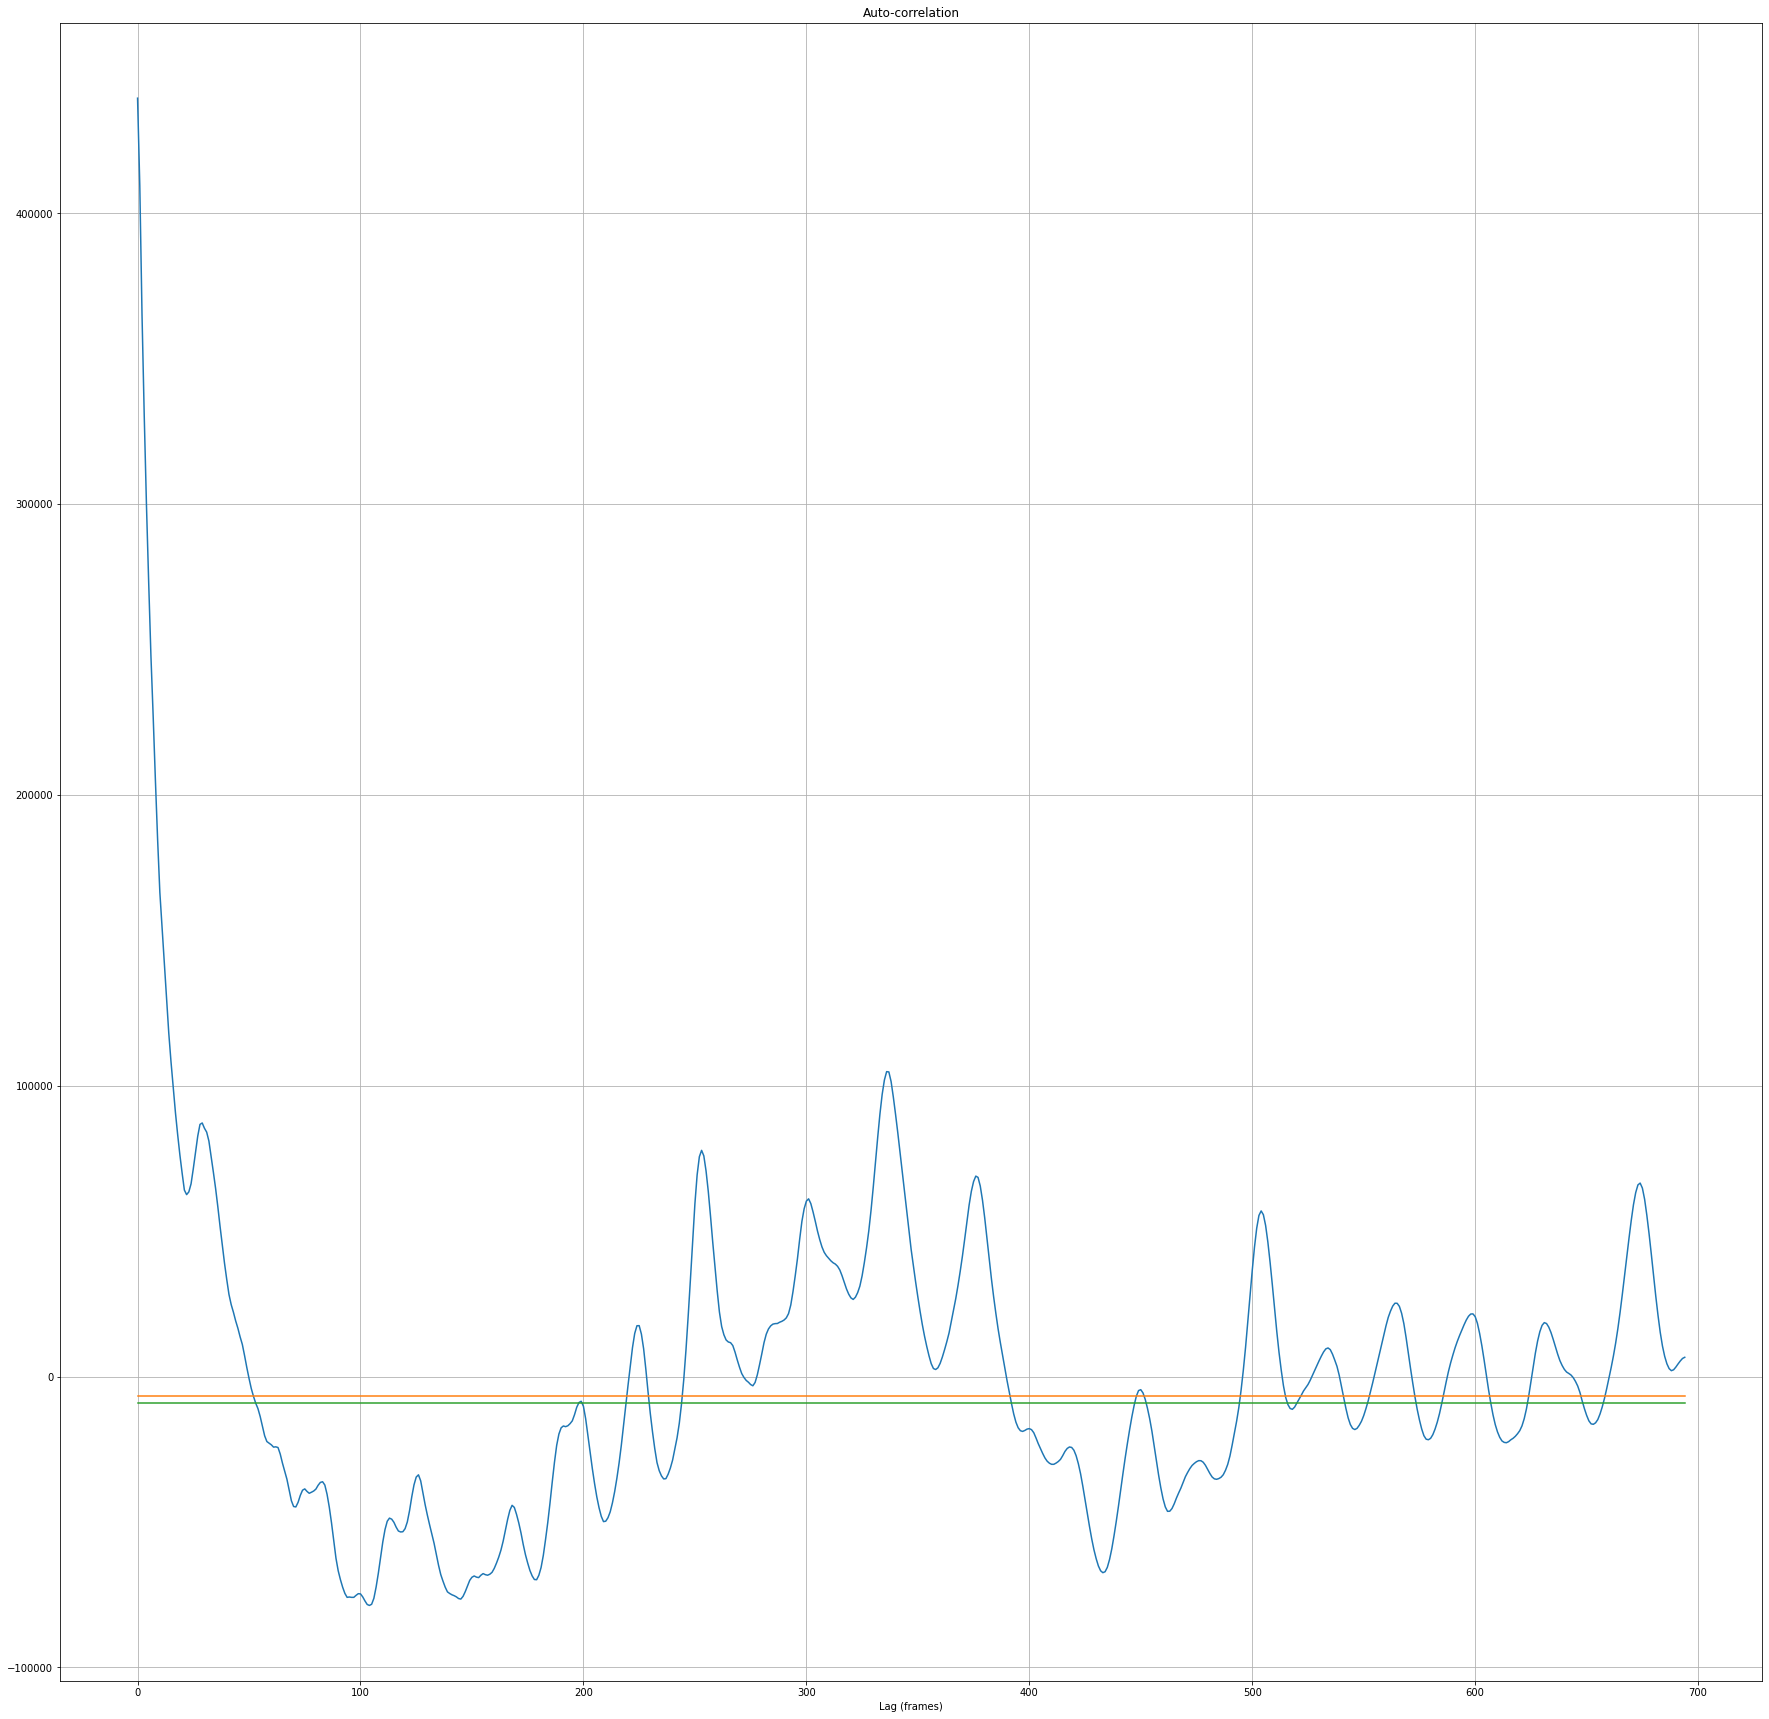

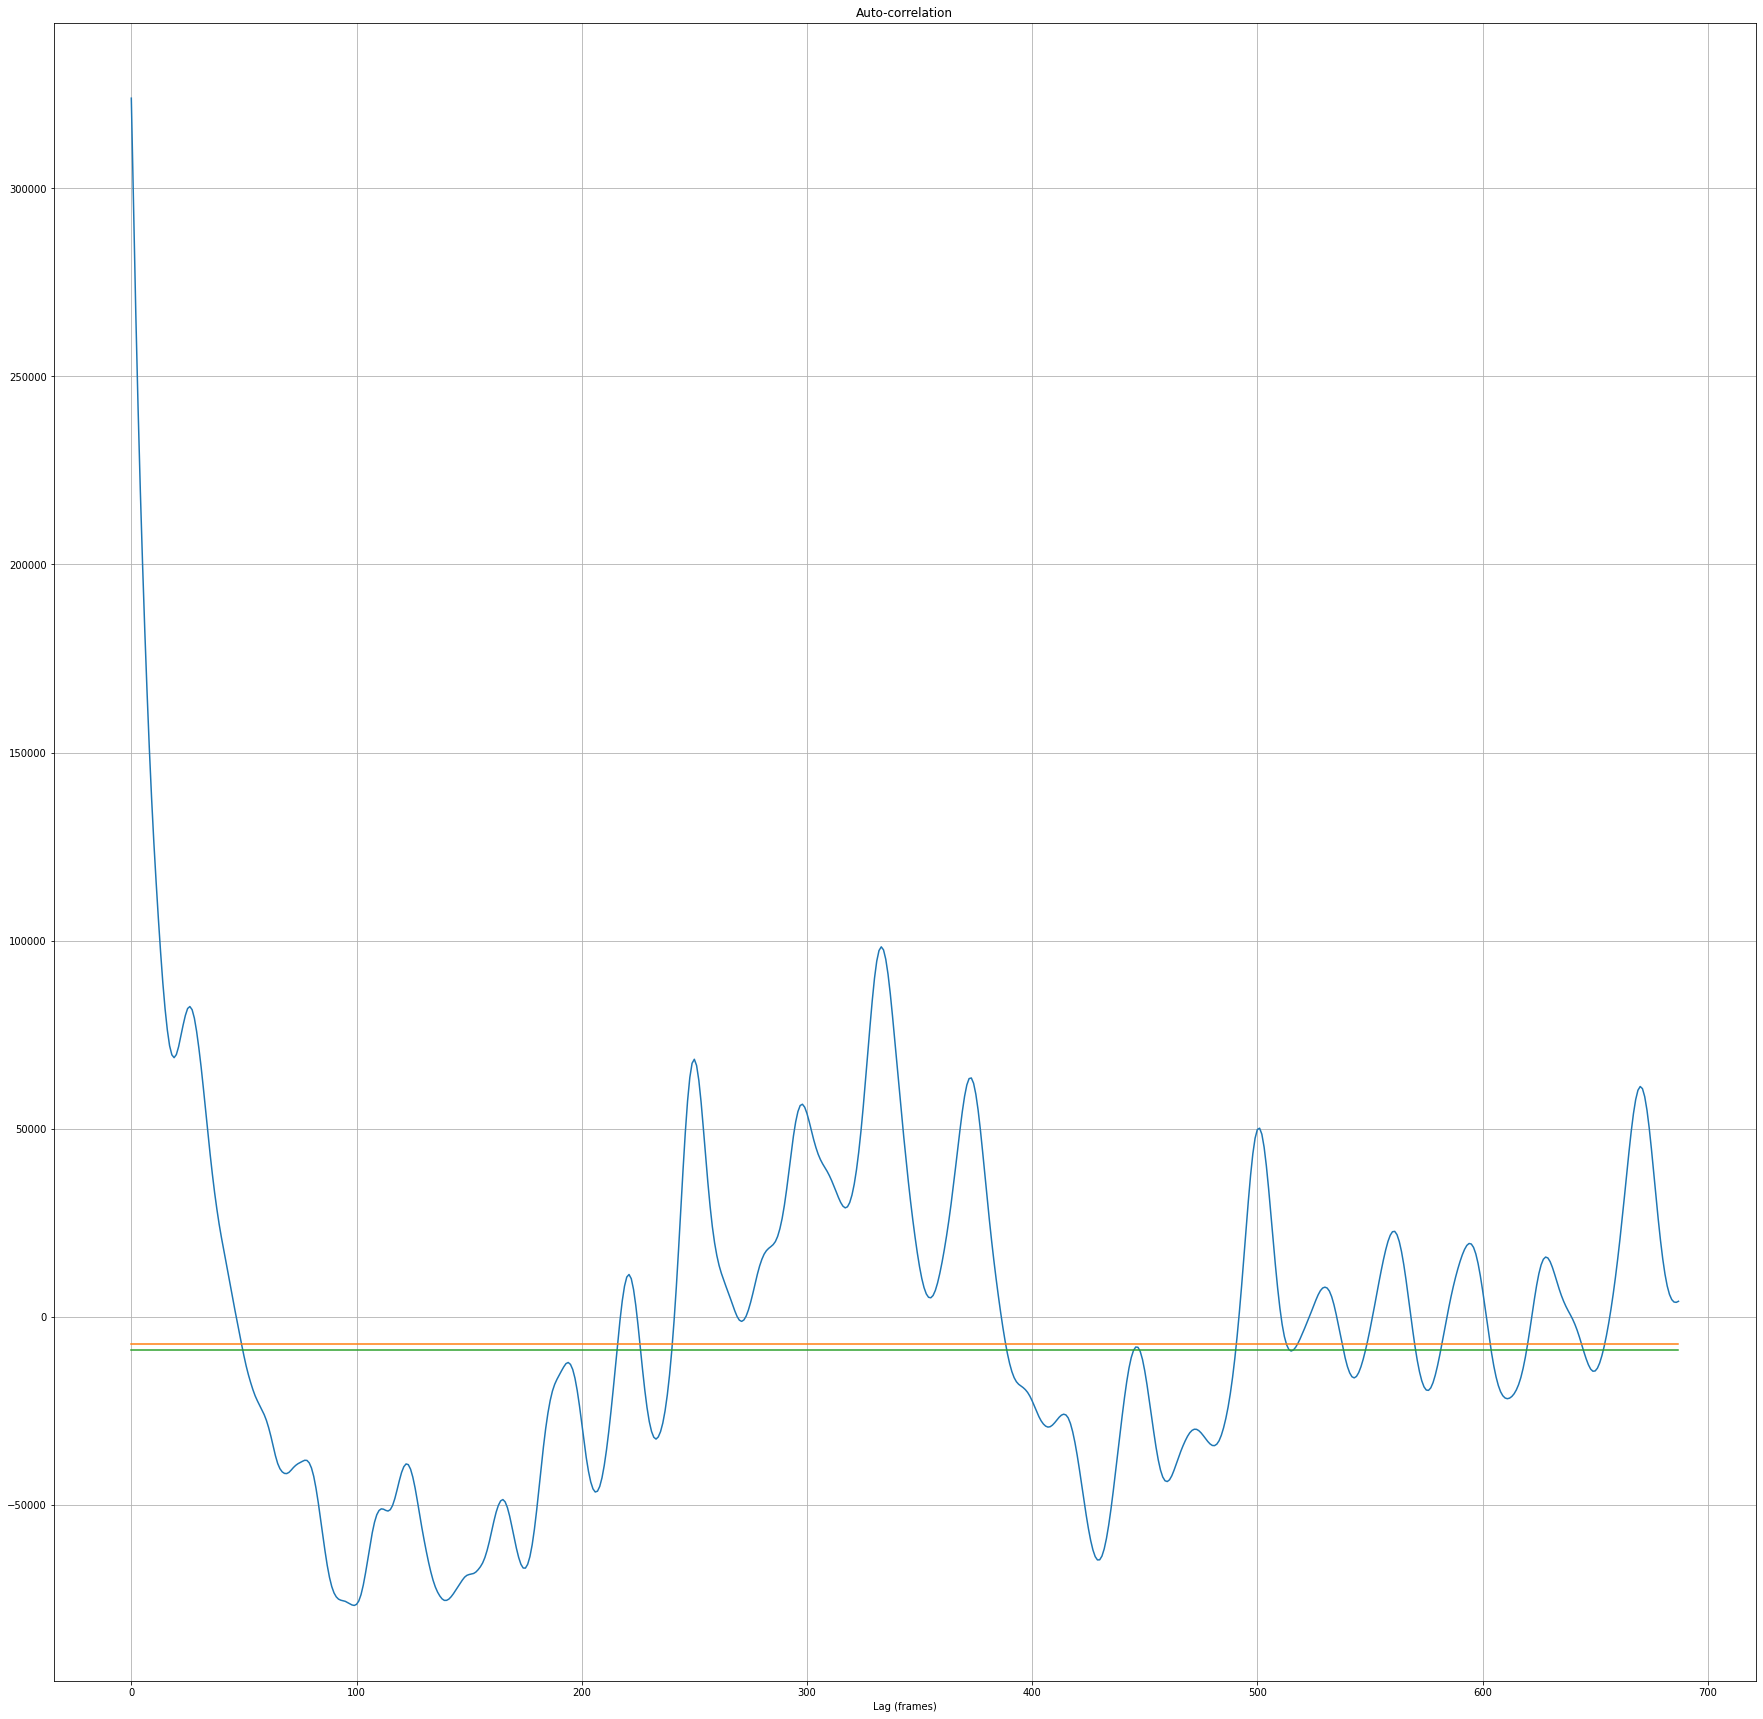

In [7]:
smoothed_ma_guns = moving_average(ac_b_guns[0], window=int(ac_b_guns[1] / 2), forecast=False)
plot_ac(ac_b_guns[0], 0.5, int(ac_b_guns[1]))
plot_ac(smoothed_ma_guns, 0.5, int(ac_b_guns[1]))

In [33]:
test_max = smoothed_ma_guns

# Catch peaks and lows - moments where differences in music pattern appear.
def catch_peak(k, tseries):
    maxis = []
    minis = []
    window = tseries.shape[0] // k
    for okno in range(k):
        maximum = okno*window + test_max[okno*window : okno*window + window].argsort()[-1:][::-1]
        minimum =  okno*window + test_max[okno*window : okno*window + window].argsort()[:1][::-1]
        maxis.append(maximum[0])
        minis.append(minimum[0])
        print(maximum[0], '\t', minimum[0])
    return [maxis, minis]

In [174]:
m = catch_peak(20, test_max)
m

0 	 33
34 	 67
77 	 99
122 	 102
165 	 139
194 	 175
221 	 206
250 	 238
298 	 272
333 	 317
340 	 355
374 	 407
441 	 429
446 	 460
501 	 481
530 	 543
561 	 576
594 	 611
628 	 612
670 	 649


[[0,
  34,
  77,
  122,
  165,
  194,
  221,
  250,
  298,
  333,
  340,
  374,
  441,
  446,
  501,
  530,
  561,
  594,
  628,
  670],
 [33,
  67,
  99,
  102,
  139,
  175,
  206,
  238,
  272,
  317,
  355,
  407,
  429,
  460,
  481,
  543,
  576,
  611,
  612,
  649]]

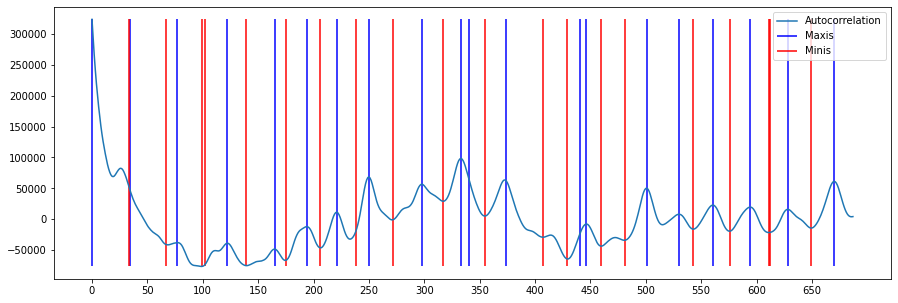

In [175]:
times = librosa.times_like(test_max)
fig, ax = plt.subplots(nrows=1, sharex=True)
# librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
#                          y_axis='log', x_axis='time', ax=ax[0])
# ax[0].label_outer()
ax.plot(test_max, label='Autocorrelation')
ax.vlines(m[0], test_max.min(), test_max.max(), label='Maxis', color='b')
ax.vlines(m[1], test_max.min(), test_max.max(), label='Minis', color='r')
ax.set_xticks(np.arange(700, step=50))
ax.legend()
ax.label_outer()
fig.set_size_inches(15, 5)

In [176]:
def transform_indexes(original_ts, transform_ts, indexes):
    len_original = original_ts.shape[0]
    len_transform = transform_ts.shape[0]
    k = len_original / len_transform
    new_peaks = [[],[]]

    for i in range(len(indexes)):
        for j in range(len(indexes[i])):
            new_peaks[i].append(int(indexes[i][j] * k))
    
    return new_peaks

In [177]:
# Transform founded peaks indexes into real time values
new_peaks = transform_indexes(b_guns[0], test_max, m)
mixed = np.append(new_peaks[0], new_peaks[1])
sorted_mix = np.sort(mixed)


In [178]:
# Generate mel-frequences for time windows we found previously

mel_array = []

n_mfcc = 40
n_fft = 2048
hop_length = 512
num_seggments = 5

for i in range(len(sorted_mix) -1):
    mfcc = librosa.feature.mfcc(b_guns[0][sorted_mix[i] : sorted_mix[i+1]],
                                sr=b_guns[1],
                                n_mfcc=n_mfcc)
# mfcc.shape
    mfcc = mfcc.T
    mel_array.append(mfcc)

In [179]:
print(mel_array[1][0])
print(mel_array[1][1])

len(mel_array)

[-489.83112    199.40753    -13.533957    38.190357    38.98625
   11.371759    10.747213   -13.767677   -24.792574    -1.1287534
   19.086388     6.264371   -14.303211    -9.071587     8.891127
    7.4461803   -3.3273406    4.020966     1.8538889   -6.0216923
    7.374205     6.8536873   -7.565913   -14.373297   -20.724136
  -23.843012   -13.29513     -1.383307    -8.735773   -19.16914
  -17.062664    -2.286981     2.822927    -7.15278    -12.111985
   -7.2216463   10.305987     9.973429    -5.291848    -6.3563137]
[-5.1428149e+02  1.9348700e+02 -7.5913043e+00  3.6243519e+01
  4.0735847e+01  6.0575829e+00  9.9125309e+00 -9.5474300e+00
 -2.0670805e+01 -2.5770080e+00  1.2355255e+01  3.8126044e+00
 -1.5760872e+01 -8.1064806e+00  1.2367310e+01  8.6652775e+00
 -1.2104609e+00  2.0703011e+00 -1.5574660e+00 -6.8210139e+00
  7.7144194e+00  1.1706151e+01 -7.0290070e+00 -1.5239164e+01
 -2.1387272e+01 -2.6701614e+01 -1.0459202e+01 -3.3929634e-01
 -1.0471155e+01 -2.2522972e+01 -2.0754869e+01 -3.02

39

[Text(0.5, 1.0, 'MFCC')]

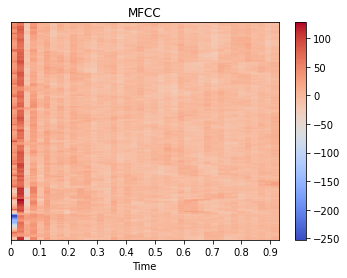

In [180]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_array[20], x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [181]:
# Find average of mel-frequency value on each time part

mel_avarages_array = []

for mel in mel_array:
    summa = 0
    c = 0
    for i in mel:
        for j in i:
            summa += j
            c += 1
            
    average = summa / c
    mel_avarages_array.append(average)

In [182]:
mixed_old = np.append(m[0], m[1])
sorted_mix_old = np.sort(mixed_old)

In [243]:
print(sorted_mix_old[17:30])

[298 317 333 340 355 374 407 429 441 446 460 481 501]


0.7040466035720891


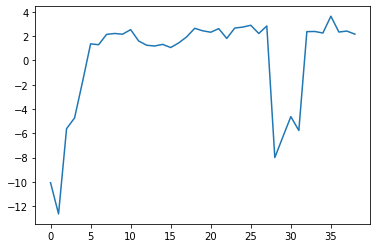

In [245]:
# for i in range(len(mel_avarages_array)):
#     print(i, '\t:', mel_avarages_array[i])
print(mel_avarages_array[18] - mel_avarages_array[17])
plt.plot(mel_avarages_array)

In [30]:
y, sr = librosa.load(librosa.ex('choice'))

In [27]:
tempo, beats = librosa.beat.beat_track(y, sr=sr)


In [43]:
beats

array([   3,   21,   40,   59,   78,   96,  116,  135,  154,  173,  192,
        211,  230,  249,  268,  287,  306,  325,  344,  363,  382,  401,
        420,  439,  458,  476,  495,  515,  534,  553,  572,  591,  610,
        629,  647,  667,  686,  705,  724,  743,  762,  780,  799,  819,
        838,  857,  876,  895,  914,  933,  951,  971,  990, 1008])

In [44]:
beat_times = librosa.frames_to_time(beats, sr=sr)

In [58]:
m[0]

[array([0]),
 array([45]),
 array([122]),
 array([165]),
 array([221]),
 array([250]),
 array([298]),
 array([333]),
 array([373]),
 array([446]),
 array([494]),
 array([501]),
 array([561]),
 array([594]),
 array([670])]

In [52]:
beat_times = librosa.frames_to_time(m[0], sr=sr)

array([ 1.02893655e-05,  1.97995882e-06,  2.52699670e-06, ...,
        4.25853887e-06, -7.86152214e-06, -1.86528869e-05], dtype=float32)

In [60]:
test_max.shape

(688,)